PART 1

In [11]:
pip install matplotlib



SyntaxError: invalid syntax (2185429697.py, line 1)

In [12]:
import matplotlib.pyplot as plt

def plot_skeleton(skeleton_points, label, title="Human Pose"):
    """
    Plot the skeleton points and display the label.
    skeleton_points: (N, 2) array of joint positions.
    label: String label of the pose.
    """
    connections = [
        (0, 1), (1, 2), (2, 3), (1, 4), (4, 5), (5, 6),  # Arms
        (1, 7), (7, 8), (8, 9), (8, 10), (10, 11), (11, 12)  # Torso and Legs
    ]
    
    plt.figure()
    for (i, j) in connections:
        x = [skeleton_points[i, 0], skeleton_points[j, 0]]
        y = [skeleton_points[i, 1], skeleton_points[j, 1]]
        plt.plot(x, y, 'bo-')
    
    plt.title(f"{title} - {label}")
    plt.gca().invert_yaxis()  # Optional: for a more natural pose orientation
    plt.grid(True)
    plt.show()


In [14]:
pip install pandas

   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
    --------------------------------------- 0.2/11.5 MB 4.6 MB/s eta 0:00:03
   -- ------------------------------------- 0.7/11.5 MB 5.1 MB/s eta 0:00:03
   --- ------------------------------------ 1.1/11.5 MB 6.6 MB/s eta 0:00:02
   ------ --------------------------------- 1.8/11.5 MB 7.5 MB/s eta 0:00:02
   -------- ------------------------------- 2.5/11.5 MB 8.9 MB/s eta 0:00:02
   ---------- ----------------------------- 3.1/11.5 MB 9.8 MB/s eta 0:00:01
   -------------- ------------------------- 4.1/11.5 MB 11.0 MB/s eta 0:00:01
   ----------------- ---------------------- 5.0/11.5 MB 11.8 MB/s eta 0:00:01
   -------------------- ------------------- 5.9/11.5 MB 12.6 MB/s eta 0:00:01
   ------------------------ --------------- 7.1/11.5 MB 13.3 MB/s eta 0:00:01
   --------------------------- ------------ 7.8/11.5 MB 13.4 MB/s eta 0:00:01
   ---------------------------- ----------- 8.2/11.5 MB 13.8 MB/s eta 0:00:01



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import pandas as pd
import numpy as np

def plot_avg_csi_amplitude(csv_file):
    df = pd.read_csv(csv_file)
    csi_columns = [col for col in df.columns if 'csi' in col.lower()]
    avg_csi = df[csi_columns].mean()
    
    plt.figure(figsize=(12, 4))
    plt.plot(avg_csi)
    plt.title("Average CSI Amplitude per Subcarrier")
    plt.xlabel("Subcarrier Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.show()


In [19]:
pip install seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ------------- -------------------------- 102.4/294.9 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:

import seaborn as sns

def plot_csi_distribution_by_class(csv_file, label_column='label'):
    df = pd.read_csv(csv_file)
    csi_columns = [col for col in df.columns if 'csi' in col.lower()]
    
    for subcarrier in csi_columns:
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=label_column, y=subcarrier, data=df)
        plt.title(f"Distribution of CSI Amplitude for {subcarrier}")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [29]:
pip install scikit-learn


     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.8 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.8/60.8 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 14.2 MB/s eta 0:00:01
   ---- ----------------------------------- 1.1/11.1 MB 10.3 MB/s eta 0:00:01
   ------- -------------------------------- 2.1/11.1 MB 12.1 MB/s eta 0:00:01
   -------- ------------------------------- 2.5/11.1 MB 11.3 MB/s eta 0:00:01
   ------------ --------------------------- 3.5/11.1 MB 12.4 MB/s eta 0:00:01
   --------------- ------------------------ 4.3/11.1 MB 13.1 MB/s eta 0:00:01
   ------------------ --------------------- 5.2/11.1 MB 13.8 MB/s eta 0:00:01
   --------------------- ------------------ 5.9/11.1 MB 14.4 MB/s eta 0:00:01
   ----------------------- ---------------- 6.4/11.1 MB 14.2 MB/s eta 0:00


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

def train_svm(csv_file, label_column='label'):
    df = pd.read_csv(csv_file)
    X = df.drop(columns=[label_column]).values
    y = df[label_column].values
    
    svm = make_pipeline(StandardScaler(), SVC(kernel='rbf', C=1.0, gamma='scale'))
    svm.fit(X, y)
    return svm


In [32]:
def predict_svm(model, csv_file):
    df = pd.read_csv(csv_file)
    X_test = df.drop(columns=['label']).values  # If test has labels
    y_test = df['label'].values  # Optional
    
    y_pred = model.predict(X_test)
    return y_test, y_pred


In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_true, y_pred))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()


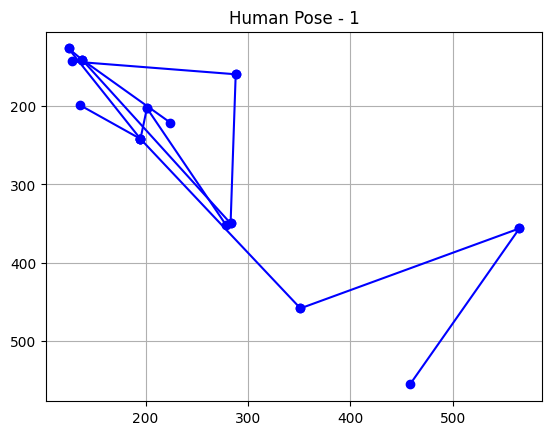

In [34]:
import pandas as pd
import numpy as np

# Load skeleton points and labels
skel_df = pd.read_csv('Train_skelletonpoints.csv', header=None)
labels_df = pd.read_csv('Train_labels.csv', header=None)

# Select one sample (e.g., index 0)
sample_index = 0
label = labels_df.iloc[sample_index, 0]
skeleton_flat = skel_df.iloc[sample_index].values
skeleton_points = skeleton_flat.reshape(-1, 2)  # Assuming 2D points

# Plot it
plot_skeleton(skeleton_points, label)


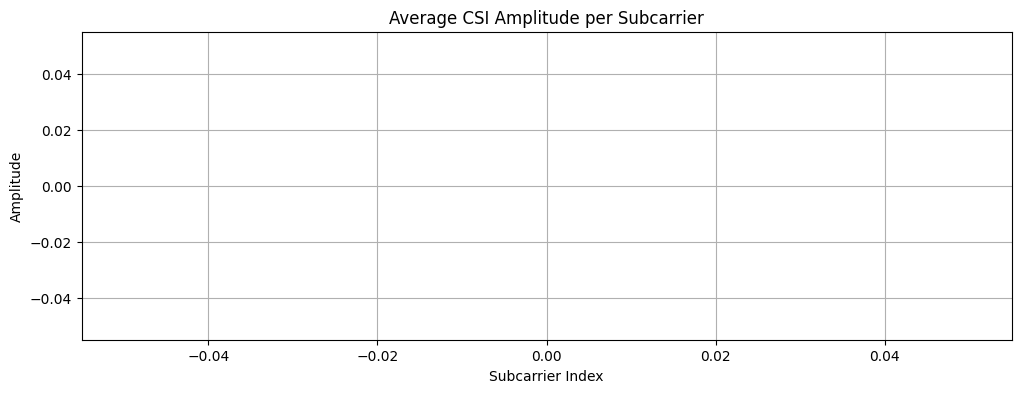

In [35]:
plot_avg_csi_amplitude('Train_features.csv')


In [38]:
features_df = pd.read_csv('Train_features.csv')
labels_df = pd.read_csv('Train_labels.csv', header=None)
print(labels_df.shape)

features_df = pd.read_csv('Train_features.csv')
features_df['label'] = labels_df[0].values  # Access the first (and only) column


plot_csi_distribution_by_class(features_df)


(1, 1000)


ValueError: Length of values (1) does not match length of index (999)